This notebook is part of the various tests for scimap. It's intended to allow for visual evaluation of fits, etc.

In [115]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import math
from matplotlib import pyplot as plt
# plt.xkcd()
import pandas as pd
import scimap
import numpy as np
from scipy import fftpack

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prepare HDF File for Later Unit Tests


In [ ]:
scimap.import_aps_34IDE_map(
    directory="test-data-xrd/xrd-map-34-ID-E/",
    wavelength=0.4959,
    shape=scimap.shape(rows=13, columns=11),
    step_size=scimap.default_units.um(1),                      
    beamstop=0.49,                            
    hdf_filename="test-data-xrd/xrd-map-34-ID-E.hdf"
);

# Corundum

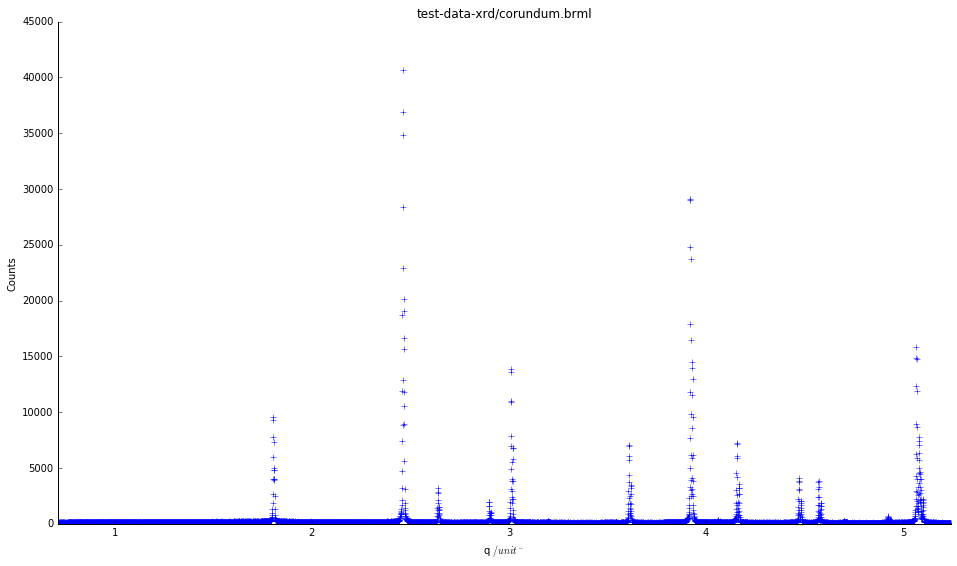

In [57]:
corundum_scan = scimap.XRDScan(filename="test-data-xrd/corundum.brml")
corundum_scan.plot_diffractogram()

## Remove a Peak

5404 5404


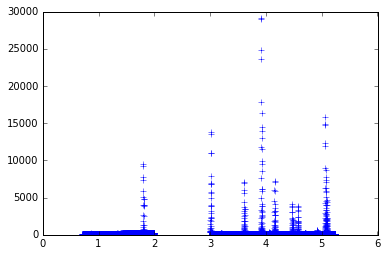

In [12]:
q, y = scimap.remove_peak_from_df(x=corundum_scan.scattering_lengths,
                          y=corundum_scan.intensities,
                          xrange=(2, 3))
print(len(q), len(y))
plt.plot(q, y, marker='+', linestyle="None")

## Peak Fitting

In [18]:
# Converted old unit-test angles to q
celref_peaks = [
            ('012', 3.4746228816945104, 25.637288649553085),
            ('104', 2.5479680737754244, 35.22223164557721),
            ('110', 2.375, 37.88141047624646),
            ('006', 2.1636666666666664, 41.74546075011751),
            ('113', 2.0820345582756135, 43.46365474219995),
            ('024', 1.7373114408472552, 52.68443192186963),
            ('116', 1.5994489779586798, 57.62940019834231),
]
two_theta = np.array([p[2] for p in celref_peaks])
scimap.twotheta_to_q(two_theta, scimap.tubes['Cu'].kalpha.num)

array([ 1.80822894,  2.46585258,  2.64543732,  2.90382698,  3.0176798 ,
        3.61645787,  3.92817384])

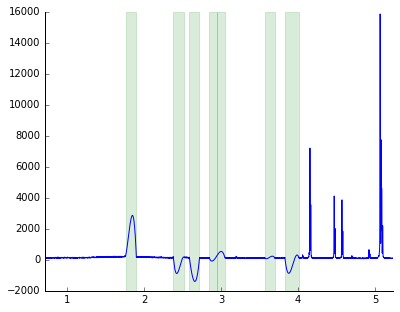

In [19]:
# Plot fitting for a peak
scan = scimap.XRDScan(filename="test-data-xrd/corundum.brml",
                     phase=scimap.standards.Corundum())
df = scan.diffractogram
scan.refinement.fit_peaks(scattering_lengths=df.index, 
                          intensities=df['subtracted'])
scan.refinement.plot(df.index)

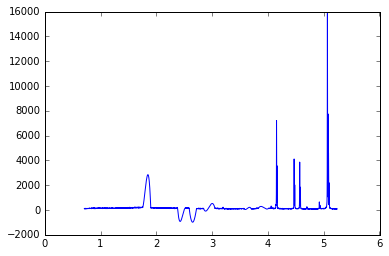

In [25]:
scan = scimap.XRDScan(filename="test-data-xrd/corundum.brml",
                     phase=scimap.standards.Corundum())
plt.plot(scan.scattering_lengths, scan.background())

# Guassian Curve for Testing Fits

/usr/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


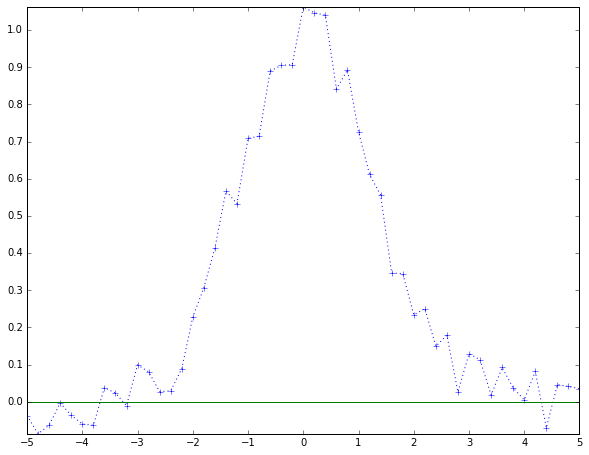

In [131]:
x = np.linspace(-5, 5, num=51)
a = 1
b = 0
c = 2 / 2*math.sqrt(2*math.log(2))
y = a * np.exp(-(x-b)**2/(2*c**2))
rands = (np.random.rand(*x.shape)-0.5) / 5
plt.figure(figsize=(0.9*11, 0.9*8.5))
plt.plot(x, y + rands, marker="+", linestyle=":")
# plt.plot(x, rands)
plt.xlim(-5, 5)
plt.xticks(np.arange(-5, 6, step=1))
plt.yticks(np.arange(0, 1.1, step=0.1));
plt.savefig('/home/mwolf/gaussian_curve.pdf')

# FFT Transform
ffty = fftpack.fft(x=y+rands)
# fftx = fftpack.fftfreq(n=x)
ffty[0:52] = 0
newy = fftpack.ifft(ffty)
# plt.figure()
plt.plot(x, newy)
# plt.plot(range(0, len(ffty)), ffty)

# Kα1/Kα1 Splitting
The graph below is based on X-ray energies taken from NIST: http://physics.nist.gov/cgi-bin/XrayTrans/search.pl?download=tab&element=All&trans=KL2&trans=KL3&lower=&upper=&units=eV

It shows that the splitting between $k_{α1}$ and $k_{α2}$ is propritional to the square of the $k_α^2$ value itself.

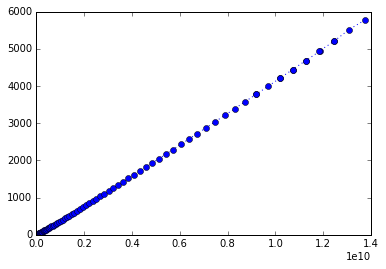

In [114]:
data = pd.read_csv('test-data-xrd/xray-energies.csv', skiprows=4, sep="\t")
kalpha1 = data[data['Trans.'] == "KL2"]
kalpha2 = data[data['Trans.'] == "KL3"]

# convert to separate numpy arrays
Z = kalpha1['Num'].values
assert np.all(np.equal(Z, kalpha2['Num'].values))
kalpha1 = kalpha1['Direct (eV)'].values
kalpha2 = kalpha2['Direct (eV)'].values

kalpha = (kalpha1 + 0.5 * kalpha2)/1.5
split = (kalpha2-kalpha1)

plt.plot(kalpha**2, split, marker="o", linestyle=":")